# Economic Dispatch

### Richard Zha

## Part 0: From last time...

In my last blog post, I presented an introduction to power markets and gave a simplified statistical model for forecasting distributions of day ahead power prices in California. While this statistical model is convenient to use and interpret, it ignores the fact that the fundamental process of how system inputs are mapped to power prices is well known (albeit, this requires a lot of information that is often not known reliably to all market participants) - namely, this is via an algorithm called Economic Dispatch.

It's been almost a year since that blog post, and as I've refined my understanding of these markets, I've been refining my understanding of dispatch along the way. Exploring these ideas in writing will hopefully help examine the complex relationship between power grid operations and trading.

I'll be mainly discussing PJM, which services a large portion of the northeastern U.S. 

## Part 1: Generator economics

Fundamentally, the grid is about stability and economics. This means that the core responsibility of any system operator is to provide power to all consumers at the cheapest prices possible, as often as possible. One dimension of this problem is that generators - being limited by physics and economics - are incredibly heterogeneous with respect to costs, flexibility, and availability.  

Let's start with costs. Cost is generally incredibly sensitive information for a generator, so there is very little public information about true costs for generators operating in PJM. The best proxy we can get is using generator bidding data, which is published by PJM; The caveat here is that the identity of all generators are hidden.  

PJM, in general, enforces that generators must bid their marginal costs, so what we see in bid data should be some kind of reflection of the costs involved in operating those units. 

The following is generator offer data for the day ahead market on 2/1/2024, found via PJM data miner 2. This offer data will highlight some of these idiosyncracies in generator economics. 

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import display, HTML

offers = pd.read_csv("energy_market_offers.csv")
offers["bid_datetime_beginning_ept"] = pd.to_datetime(
    offers["bid_datetime_beginning_ept"]
)
offers = offers.set_index("bid_datetime_beginning_ept").sort_index()
display(offers)

,bid_datetime_beginning_utc,unit_code,bid_slope_flag,mw1,mw2,mw3,mw4,mw5,mw6,mw7,...,inter_start_cost,hot_start_cost,max_daily_starts,min_runtime,max_ecomax,min_ecomax,avg_ecomax,max_ecomin,min_ecomin,avg_ecomin
bid_datetime_beginning_ept,,,,,,,,,,,,,,,,,,,,,
2024-02-01 00:00:00,2/1/2024 5:00:00 AM,CQUKBAcOBQcXNTQxNzExMDE,True,150.0,300.0,450.0,600.0,750.0,900.0,1300.0,...,0.00,0.00,1,24.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0
2024-02-01 00:00:00,2/1/2024 5:00:00 AM,AgAHBQ4LAgUXODkxMDQxMDE,False,20.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,99999,NaN,17.0,17.0,17.0,17.0,17.0,17.0
2024-02-01 00:00:00,2/1/2024 5:00:00 AM,AgAHBQ4LAQMXODkxMzQxMDE,False,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,99999,NaN,0.8,0.8,0.8,0.8,0.8,0.8
2024-02-01 00:00:00,2/1/2024 5:00:00 AM,AgAHBQ4LBg8XODkwNTQxMDE,False,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,99999,NaN,0.8,0.8,0.8,0.8,0.8,0.8
2024-02-01 00:00:00,2/1/2024 5:00:00 AM,AgAHBQ4LBQMXODkwODQxMDE,False,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,99999,NaN,16.0,16.0,16.0,16.0,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-01 23:00:00,2/2/2024 4:00:00 AM,BAIBBQEIARgMMjMxMjEwMg,True,NaN,160.0,161.0,285.0,285.1,301.9,302.0,...,0.00,0.00,1,6.0,295.0,295.0,295.0,160.0,160.0,160.0
2024-02-01 23:00:00,2/2/2024 4:00:00 AM,BAIBBQEIBRgMMTA3MDEwMQ,False,182.0,184.0,NaN,NaN,NaN,NaN,NaN,...,7608.00,7608.00,4,2.0,184.0,184.0,184.0,182.0,182.0,182.0
2024-02-01 23:00:00,2/2/2024 4:00:00 AM,BAIBBQEJAhgBMDUyMjEwMg,False,49.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4670.14,4670.14,6,1.0,49.0,49.0,49.0,47.0,47.0,47.0


## Offer curves

The day ahead market operates, as the name implies, one day ahead of operation. Each hour of the following operating day is cleared at the same time, so this means that to understand costs, it only really makes sense to look cross sectionally at each hour. Let's look at the first hour:

In [135]:
hour_0 = pd.to_datetime("2024-02-01 00:00:00")
hour_0_offers = offers.loc[hour_0]
hour_0_offers.columns

Index(['bid_datetime_beginning_utc', 'unit_code', 'bid_slope_flag', 'mw1',
       'mw2', 'mw3', 'mw4', 'mw5', 'mw6', 'mw7', 'mw8', 'mw9', 'mw10', 'mw11',
       'mw12', 'mw13', 'mw14', 'mw15', 'mw16', 'mw17', 'mw18', 'mw19', 'mw20',
       'bid1', 'bid2', 'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9',
       'bid10', 'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17',
       'bid18', 'bid19', 'bid20', 'no_load_cost', 'cold_start_cost',
       'inter_start_cost', 'hot_start_cost', 'max_daily_starts', 'min_runtime',
       'max_ecomax', 'min_ecomax', 'avg_ecomax', 'max_ecomin', 'min_ecomin',
       'avg_ecomin'],
      dtype='object')

The columns we're interested in here are mainly **mwx** and **bidx**, which describe a tuple (mw, bid) for the generator's *offer curve* - the generator's offer price as a function of output. $(\text{mw}_1, \text{bid}_1)$ describes the first point on the curve, $(\text{mw}_2, \text{bid}_2)$ the second, and so on. The column **bid_slope_flag** indicates how the generator wants to interpolate their offer points. Setting bid_slope_flag=1 indicates that the generator wants to linearly interpolate their offer curve, whereas bid_slope_flag=0 indicates that the offer curve is a step function. PJM enforces that every generator offer curve is strictly monotonically increasing.

This is the offer curve for anonymous unit **CQUKBAcOBQcXNTQxNzExMDE**:

In [74]:
anon_unit = "CQUKBAcOBQcXNTQxNzExMDE"
mw_labels = ["mw" + str(i) for i in range(1, 21)]
bid_labels = ["bid" + str(i) for i in range(1, 21)]
unit_offers = hour_0_offers[hour_0_offers["unit_code"] == anon_unit]

# flatten the columns into an np.array
mws = unit_offers[mw_labels].dropna(axis=1).to_numpy().flatten()
bids = unit_offers[bid_labels].dropna(axis=1).to_numpy().flatten()

# the generator interpolated their offer curve
assert unit_offers["bid_slope_flag"].item() == True

This generator offered with linear interpolation, so we can just plot directly with matplotlib:

Text(0.5, 1.0, 'Unit Offer Curve on 2/1/2024 Hour 0')

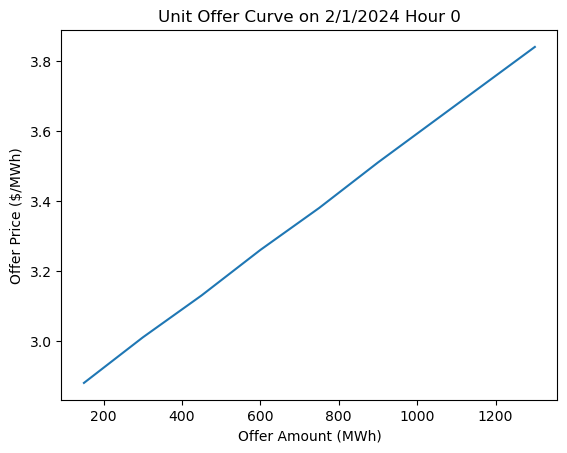

In [67]:
plt.plot(mws, bids)
plt.xlabel("Offer Amount (MWh)")
plt.ylabel("Offer Price ($/MWh)")
plt.title("Unit Offer Curve on 2/1/2024 Hour 0")

We can see that this particular generator offered basically a straight line. Roughly speaking, the generator offered in at ~3.3 $/MWh for this hour. What do the costs of other generators look like?

To reduce the dimensionality of this problem a bit, we'll take the average of the "bid" columns for each unit, so that each unit gets exactly one data point. Note that this is not mathematically the average of the offer curve for each generator due to the interpolation. This abstraction of using a single data point per generator is usually called the *bid stack*.

For the mw amount of each generator, we'll instead replace it with the generation capacity of each unit, indicated by the **max_ecomax** column. This indicates the maximum MW amount that the generator can economically operate at for their offer curve.

In [211]:
# find the mean of all bids
hour_0_offers.loc[:, "avg_offer"] = (
    hour_0_offers[bid_labels].copy().mean(axis=1, skipna=True)
)
hour_0_offers = hour_0_offers.sort_values("avg_offer")

# because we want to view the cumulative capacity of the generation fleet, take the cumsum()
hour_0_offers.loc[:, "cum_ecomax"] = hour_0_offers["max_ecomax"].cumsum()

# get (cumulative ecomax, avg_offer) tuples
bid_stack = (
    hour_0_offers[["cum_ecomax", "avg_offer"]].dropna().apply(tuple, axis=1).tolist()
)
bid_stack[:10]

[(0.0, -208.67),
 (24.0, -90.0),
 (57.0, -90.0),
 (113.0, -77.5),
 (169.0, -77.5),
 (210.0, -75.0),
 (370.4, -72.41),
 (419.0, -72.41),
 (497.5, -70.54),
 (640.4, -68.7)]

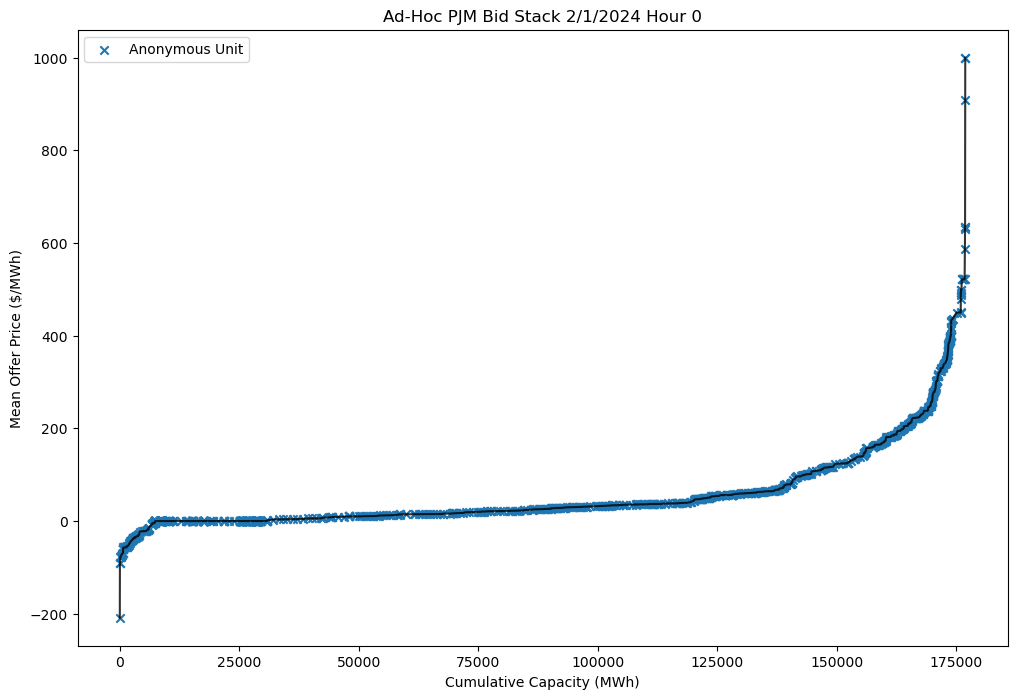

In [205]:
plt.figure(figsize=(12, 8))
plt.xlabel("Cumulative Capacity (MWh)")
plt.ylabel("Mean Offer Price ($/MWh)")
plt.title("Ad-Hoc PJM Bid Stack 2/1/2024 Hour 0")
plt.scatter(hour_0_offers["cum_ecomax"], hour_0_offers["avg_offer"], marker="x")
plt.plot(hour_0_offers["cum_ecomax"], hour_0_offers["avg_offer"], alpha=0.8, color='black')
plt.legend(['Anonymous Unit'])

We can see that our chosen anonymous generator is pretty cheap, at least when compared to other generators in the stack. This bid stack is also pretty accurate in terms of visualizing the general costs of each unit. See the generation stack show in this document by NREL: https://www.nrel.gov/docs/fy17osti/67106.pdf. 

![PJM Stack](pjmstack.png)

It should be clear that costs vary greatly between generator types. The most expensive units in the stack are almost always oil/diesel related, which has to do with how expensive oil is, and how inefficient many of these generators are. Renewables will always be very cheap compared to coal/gas/oil. Notice that some units in PJM can even offer negative prices. This reflects the idea that power is, in general, economically unstorable at large scales - the result is that it may actually be cheaper to sell at negative prices than attempt to store power if a renewable source overproduces. 

## Operational flexibility

Generators are very different in terms of how fast they can start up, how long they have to run before shutting down, and many other operational characteristics.

Take the anonymous unit from before:

In [142]:
unit_offers[["max_daily_starts", "min_runtime", "avg_ecomax", "avg_ecomin"]]

,max_daily_starts,min_runtime,avg_ecomax,avg_ecomin
bid_datetime_beginning_ept,,,,
2024-02-01,1,24.0,1272.0,1272.0


This anonymous unit can only start up once a day at most, indicated by the max_daily_starts column. They also must run for 24 hours before they can shut down, indicated by the min_runtime column. In conjunction with the size of the generator, indicated by ecomax, it is obvious that this generator is very inflexible in how they operate, and is a very large generator. These are pretty typical characteristics of nuclear generators. Now, take another anonymous unit with unit code **AgAHBQ4LAgUXODkxMDQxMDE**:

In [141]:
other_anon_unit = "AgAHBQ4LAgUXODkxMDQxMDE"
other_unit_offers = hour_0_offers[hour_0_offers["unit_code"] == other_anon_unit]
other_unit_offers[["max_daily_starts", "min_runtime", "avg_ecomax", "avg_ecomin"]]

,max_daily_starts,min_runtime,avg_ecomax,avg_ecomin
bid_datetime_beginning_ept,,,,
2024-02-01,99999,NaN,17.0,17.0


This new unit can essentially start up as many times as it wants throughout the day (the 99999 is a placeholder value that generators can input when they have no restriction on number of start ups). This unit also does not have a minimum runtime, implying that at least on a timescale of hours, there is no minimum amount of time that it must be on before it can shut down. 

In [145]:
other_unit_offers[bid_labels].dropna(axis=1)

,bid1
bid_datetime_beginning_ept,
2024-02-01,0.0


As these two examples indicate, heterogeneity in both costs and operations make coordinating a generation fleet a very difficult problem, especially when the rest of the grid is also considered. 

## Part 2: Economic Dispatch

Now, we'll explore how we could dispatch this set of generators to satisfy demand and clear the energy market. 
For the remainder of this blog post, assume that all generators are already running (figuring out which generators to turn on and off is actually a more difficult problem called *unit commitment*; Unit commitment is a mixed integer linear program (MILP), which is known to be NP-hard.)

A typical assumption to make is that demand for power is constant and price inelastic. This means that we will take demand to not be a function of price. 

How should we determine the cheapest way to dispatch this set of generators?

## Simple model: no transmission network

Start by assuming that there is no transmission network. How should we determine dispatch? A natural idea is to simply minimize costs by greedily dispatching the cheapest generation available until we have fulfilled demand. Thus, clearing the market involves intersecting our constant demand with the bid stack. The last unit that has to be dispatched is called the *marginal unit*, because their costs will set the price of energy for all participants.

For convienence, we'll use the numpy interpolate() function, which will let us use the bid stack from above as a linearly interpolated set of points (recall that each generator was exactly one point on the bid stack). 

Suppose that demand for hour 0 is 75000 MWh. Clearing the market, we can find the price of energy in this model:

Market cleared at: 19.85 ($/MWh)


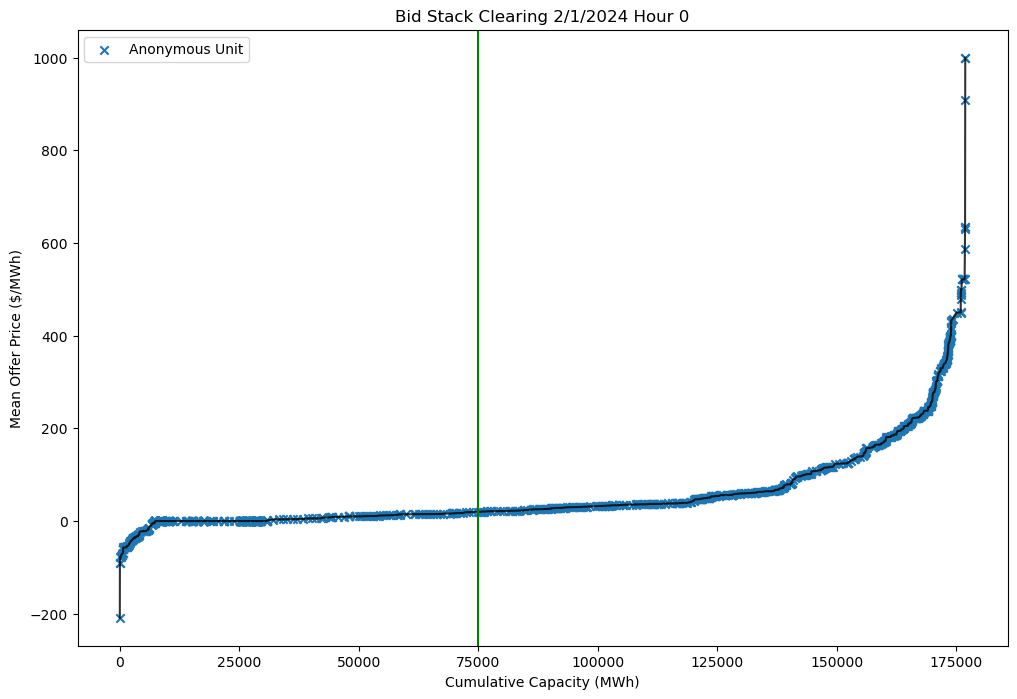

In [209]:
# Given a constant demand and bidstack, clear the market and plot results
def clear_market(demand, bid_stack): 
    
    cum_mws = [cum_mw for (cum_mw, avg_offer) in bid_stack]  # get the mw data points
    avg_offers = [avg_offer for (cum_mw, avg_offer) in bid_stack]  # get the bid data points

    cleared_price = np.interp(demand, cum_mws, avg_offers)
    print(f"Market cleared at: {round(cleared_price, 2)} ($/MWh)")

    plt.figure(figsize=(12, 8))
    plt.xlabel("Cumulative Capacity (MWh)")
    plt.ylabel("Mean Offer Price ($/MWh)")
    plt.title("Bid Stack Clearing 2/1/2024 Hour 0")
    plt.scatter(hour_0_offers["cum_ecomax"], hour_0_offers["avg_offer"], marker="x")
    plt.plot(hour_0_offers["cum_ecomax"], hour_0_offers["avg_offer"], alpha=0.8, color='black')
    plt.legend(['Anonymous Unit'])
    plt.axvline(demand, color="green")
    
clear_market(75000, bid_stack)

What if demand is at 165000 MWh?

Market cleared at: 210.26 ($/MWh)


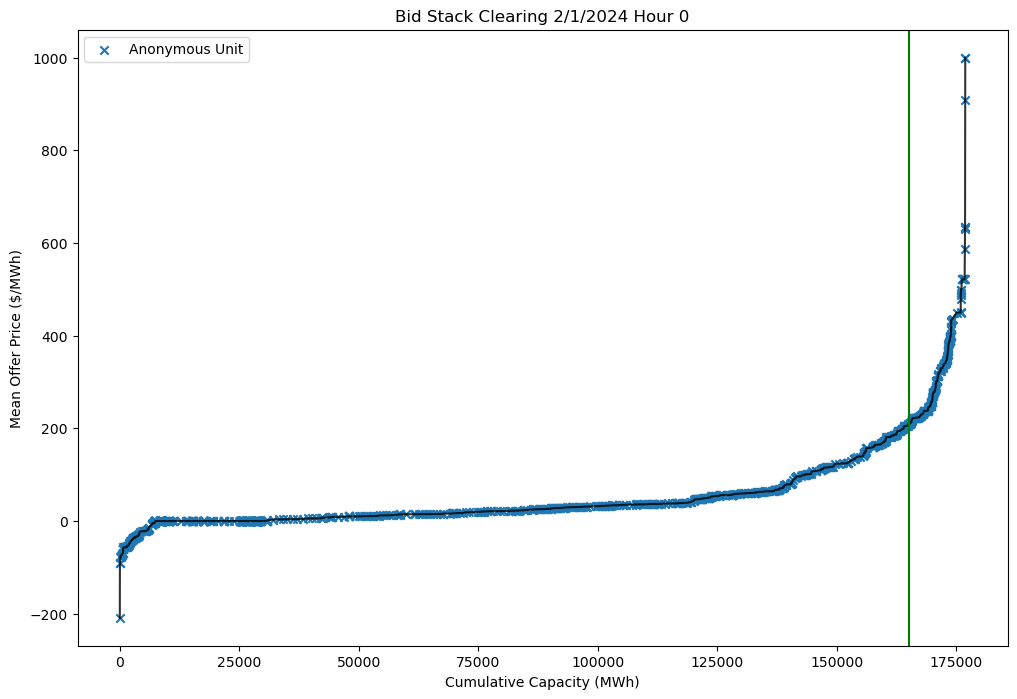

In [210]:
clear_market(165000, bid_stack)

Increasing demand means that we have to dispatch more and more of the stack, which could result in dispatching very expensive units, increasing the price of energy for all participants. Essentially, figuring out the price that clears the market is equivalent to figuring out the costs of the unit that will be on the margin when we try to balance supply and demand. This means that having good forecasts of demand (which is a heavily studied topic in literature) and a good understanding of supply (which generators are on outage, what their costs are, what their nameplate capacity is) is how we could attempt to get a good forecast of power price. 

## (Slightly) more realistic: Locational Marginal Pricing (LMPs)

While the above model is economically very easy to interpret, in realistic grids we will have to transmit energy across lines when generators are dispatched. The power grid can be viewed as a graph - nodes in the graph are referred to as *buses*, which can have both loads and generators situated at that bus. Transmission lines are all rated for a given *capacity*, which is the maximum amount of energy that can flow along that line safely. 

Consider a simple hypothetical scenario of a two bus system, with bus $b_A$ and bus $b_B$, with one line $b_A \rightarrow b_B$ connecting them. $b_A$ has a generator $g_A$ which has a marginal cost of 30 \\$/MWh and $b_B$ has a generator $g_B$ which has a marginal cost of 100 \\$/MWh. Suppose that both generators are very large and already running, and that there is a fixed 100 MW demand at bus $A$ and bus $B$. If we assume that the transmission line $A \rightarrow B$ has no limit on capacity, the previous model suggests that we can just dispatch $g_A$ to be the marginal unit and serve 200 MW (100 MW each at $b_A$ and $b_B$), setting the clearing price to be 30 \\$/MWh at both buses. 

Now, assume that the capacity on line $b_A \rightarrow b_B$ is 50 MW. At $b_A$, we can simply use $g_A$ to serve the 100 MW of demand. However, because the capacity of $b_A \rightarrow b_B$ does not allow us to transmit more than 50 MW, at $b_B$ we have to dispatch $g_B$ to cover the last 50 MW of demand at $b_B$. 

Because different units are on the margin at each bus, there is an indirect cost associated with the transmission line limiting how much cheap generation we can use to serve both buses. When prices are allowed to vary at each node, this is called *locational marginal pricing*, or LMPs. Thus, the LMP at $b_A$ would be 30 \\$/MWh, and 100 \\$/MWh at $b_B$.

So how do we compute LMPs in realistic sized grids? First, we need to determine the cheapest dispatch possible, subject to the constraints that we (1) do not overload transmission lines, (2) do not overproduce at any given generator, and (3) obey power flow equations. In general, this is called the AC economic dispatch problem, or the optimal power flow problem. 

## Linearized (DC) optimal power flow

For brevity, the nitty gritty details of power flow will be omitted here. Skipping over many details, in AC power flow, we allow power to have both a real and imaginary component. The result is that we get a set of power flow equations that is both non-linear and non-convex, meaning that the solving the market (in addition to solving unit commitment) becomes very difficult. To simplify this, people often solve a linearized version of the economic dispatch problem. This linearization is used for the day ahead market. 

Let $p_{i,j}$ be the real power along a line going from bus $i$ to bus $j$, and similar for $q_{i,j}$ as the reactive power. The AC power flow equations are: 

$$p_{i,j} = \frac{1}{r_{i,j}^2 + x_{i,j}^2}(r_{i,j}(v_i^2 - v_iv_j\cos(\delta_{i,j})) + x_{i,j}(v_iv_j\sin(\delta_{i,j})))$$

$$q_{i,j} = \frac{1}{r_{i,j}^2 + x_{i,j}^2}(x_{i,j}(v_i^2 - v_iv_j\cos(\delta_{i,j})) + r_{i,j}(v_iv_j\sin(\delta_{i,j})))$$

Where $r_{i,j}$ is the resistance of the line, $x_{i,j}$ is the reactance, $v_i$ is the voltage at bus $i$, and $\delta_{i,j}$ is the bus angle difference between bus $i$ and $j$. 

The linearized power flow model assumes that: 
- $r_{i,j} \approx 0$. This means that we assume that resistance is negligible, implying that the system is loseless. 
- $v_i, v_j \approx 1$. 
- $\delta_{i,j} \approx 0$, so $\cos(\delta_{i,j}) \approx 1$ and $\sin(\delta_{i,j}) \approx \delta_{i,j}$. 

These assumptions simplify the power flow equations to be:

$$p_{i,j} \approx \frac{\delta_{i,j}}{x_{i,j}}$$
$$q_{i,j} \approx 0$$

Which are called the linearized power flow equations. Notice that in this model, we do not have reactive power flow. 

## Mathematical programming formulation

Let $c_g(x)$ be the cost function of dispatch for generator $g$ at $x$ MW output, $\delta_i$ be the bus angle at bus $i$, $p_{i,j}$ be the power flow along a line from $i$ to $j$, $p_g$ be the dispatch at generator $g$, and $p_l$ be the load at a load point $l$. 


For brevity, let $s$ represent the three tuple of $(\delta, p_g, p_{i,j})$, which will be the decision variables. Additionally, let $G$ be the set of generators, $L$ be the set of loads/demand, $E$ be the set of edges (lines), and $N$ be the set of buses. 

Then, the linearized economic dispatch problem is: 

$$
\min_{s} \sum_{g \in G} c_g(p_g) \\
$$
$$\text{subject to} \\$$
1. 
$$\sum_{g \in G_i} p_g - \sum_{l \in L_i} p_l = \sum_{(i,j) \in E} p_{i,j}, \forall i \in N$$
2. 
$$p_{i,j} = \frac{\delta_{i,j}}{x_{i,j}}, \forall (i,j) \in E$$
3.
$$p_g^{L} \leq p_g \leq p_g^{U}, \forall g \in G$$
4.
$$\delta_{i,j}^{L} \leq \delta_{i,j} \leq \delta_{i,j}^{U}, \forall (i,j) \in E$$
5.
$$|p_{i,j}| \leq p_{i,j}^{U}, \forall (i,j) \in E$$

Typically, the cost function is represented using a quadratic equation, or using a piecewise linear function like the PJM offer data. 

A key idea here is that the above model is equivalent to the bid stack when no transmission constraints saturate. That is, the economic dispatch algorithm will simply pick cheapest generation until demand is fulfilled, satisfying constraint (1). This constraint is usually called the *power balance constraint*, because it enforces that supply and demand are balanced at each node, when accounting for incoming/outgoing flows at each node. This is basically exactly what the bid stack does. 

When we do have transmission constraint saturate, they are called *binding constraints*. We saw in the LMP hypothetical above that this will cause a price difference between nodes. What will the price difference be? It will be exactly the shadow price of the binding constraint. The shadow price for transmission constraints are caused by being forced to dispatch more expensive generation. 

Typically, a conceptual way that this is presented for loseless power flow models is to think of $\text{LMP} = \text{Balance} + \text{Congestion}$ (in reality, there is also a loss component), where balance is the cost of balancing supply and demand, and congestion refers to shadow prices from binding constraints. In other words, LMPs are computed as the sum of (relevant) shadow prices on the constraints defined in the **dual** of the economic dispatch problem. 

## Toy Economic Dispatch Model


We'll create a dispatch model using pyomo, a optimization language framework for python. Test data is sourced from a TAMU case for ERCOT (Texas), which defines all buses, generators, lines in the network: https://electricgrids.engr.tamu.edu/ 

We'll ignore status for branches and generators, in order to simplify the code as much as possible.

In [173]:
class Bus:  # a bus is a node in the graph with demand, generators, and branches in/out
    def __init__(self, n, t, i, l):
        self.name = n
        self.type = t
        self.id = i
        self.load = l  # real power load at this bus
        self.gens = []  # set of generators at this bus
        self.out_edges = {}  # branch id : bus dict
        self.in_edges = {}  # branch id : bus dict

    def __repr__(self):
        return f"{self.name}, {self.type}, {self.id}, {self.load}"


class Generator:
    _idx = 0

    def __init__(
        self, pts, at_bus_id, s, pmin, pmax
    ):  # pts is a set of (mw, cost) pairs
        self.pts = np.array(pts)
        self.cost_f = lambda mw: self.pts[-1, 1] / self.pts[-1, 0]  # constant cost/MW
        self.at_bus_id = at_bus_id  # the bus where the gen is located
        self.status = s  # whether the generator is off or not at t0
        self.pmin = pmin  # minimum real power output
        self.pmax = pmax  # maximum real power output
        self.pg = 0  # MW power to produce at this generator
        self.id = Generator._idx
        Generator._idx += 1

    def __repr__(self):
        return f"{self.at_bus_id}, {self.status}, {self.pmin}, {self.pmax}"

    def __call__(self, mw):  # return the cost at a mw amount
        return self.cost_f(mw)

    def get_cost_breakpts(self):  # return the mw breakpoints in cost func
        return self.pts[:, 0].tolist()


class Branch:
    _idx = 0

    def __init__(self, fb, tb, x, s, r):
        self.from_bus = fb  # from bus i id
        self.to_bus = tb  # to bus j id
        self.x = x  # reactance of the line in p.u
        self.status = s  # whether the branch is off
        self.rating = r  # line rating in MWA (same in MW)
        self.flow = 0
        self.id = Branch._idx
        Branch._idx += 1

    def __repr__(self):
        return f"{self.from_bus}, {self.to_bus}, {self.x}, {self.status}, {self.rating}"

In [194]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from component import Bus, Branch, Generator
from pyomo.opt import TerminationCondition
import numpy as np
import pandas as pd


class Network:  # a graph of the electrical grid

    def __init__(self):
        self._model = pyo.ConcreteModel()
        self.bus_set = {}  # mapping from bus id -> Bus object
        self.gen_set = {}
        self.branch_set = {}
        self.slack_bus = None
        self.built = False

    def build(self):  # build the optimization problem
        def cost_func(m, gen_id, mw):
            return self.gen_set[gen_id](mw)  # call the generator cost function at MW

        def init_gen_out_lim(m, gen_id, level):  # init the gen limit parameter
            if level == "min":
                return self.gen_set[gen_id].pmin
            return self.gen_set[gen_id].pmax

        def init_flow_lim(m, branch_id, level):  # init the flow limit parameter
            if level == "min":
                return -self.branch_set[branch_id].rating
            return self.branch_set[branch_id].rating

        def gen_lim_rule(m, gen_id):  # bounds on generator output from param
            return (m.gen_out_lim[gen_id, "min"], m.gen_out_lim[gen_id, "max"])

        def flow_lim_rule(m, branch_id):  # bounds on line flow from param
            return (m.line_rating[branch_id, "min"], m.line_rating[branch_id, "max"])

        self._model.gen_out_lim = pyo.Param(
            self.gen_set.keys(), ["min", "max"], initialize=init_gen_out_lim
        )
        self._model.line_rating = pyo.Param(
            self.branch_set.keys(), ["min", "max"], initialize=init_flow_lim
        )
        self._model.total_load = pyo.Param(
            initialize=sum([b.load for b in self.bus_set.values()])
        )

        self._model.pg = pyo.Var(
            self.gen_set.keys(),
            domain=pyo.Reals,
            initialize=lambda m, x: (self.gen_set[x].pmin),
            bounds=gen_lim_rule,
        )

        self._model.f_k = pyo.Var(
            self.branch_set.keys(), domain=pyo.Reals, bounds=flow_lim_rule
        )  # the flow along line k
        self._model.theta_b = pyo.Var(
            self.bus_set.keys(), domain=pyo.Reals, bounds=(-180, 180), initialize=0
        )  # the voltage angle at bus b

        @self._model.Constraint(self.branch_set.keys())
        def power_flow(m, branch_id):
            branch = self.branch_set[branch_id]
            return m.f_k[branch_id] == (1 / branch.x) * (
                m.theta_b[branch.from_bus] - m.theta_b[branch.to_bus]
            )

        @self._model.Constraint(
            self.bus_set.keys()
        )  # enforce flow conservation at each bus
        def demand(m, bus_id):
            out_edge_flow = sum(
                [
                    m.f_k[branch_id]
                    for branch_id in self.bus_set[bus_id].out_edges.keys()
                ]
            )
            in_edge_flow = sum(
                [m.f_k[branch_id] for branch_id in self.bus_set[bus_id].in_edges.keys()]
            )

            gen_amt = sum([m.pg[gen.id] for gen in self.bus_set[bus_id].gens])
            load = self.bus_set[bus_id].load
            return gen_amt - load == out_edge_flow - in_edge_flow

        @self._model.Constraint()
        def slack_bus_ang(m):
            return m.theta_b[self.slack_bus.id] == 0

        @self._model.Objective(sense=pyo.minimize)
        def obj(m):
            # eval generator cost function at the generated amount
            return sum(
                [
                    self.gen_set[gen_id](m.pg[gen_id]) * m.pg[gen_id]
                    for gen_id in self.gen_set.keys()
                ]
            )

        self.built = True
        self._model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
        return self.built

    def solve(self, solver="glpk"):
        opt = SolverFactory(solver)
        res = opt.solve(self._model, options={"threads": 4})
        assert res.solver.status == pyo.SolverStatus.ok
        assert res.solver.termination_condition == pyo.TerminationCondition.optimal

        # write output to dataframe
        out = pd.DataFrame(index=self.bus_set.keys(), columns=["LMP"])

        out.index.name = "Bus"
        for bus_idx in self._model.demand:
            # price (balance) constraint at this node
            out.loc[bus_idx, "LMP"] = self._model.dual[self._model.demand[bus_idx]]
        return out

    def add_bus(self, bus):  # add a node to the graph
        self.bus_set[bus.id] = bus

        if bus.type == 3:  # type 3 bus are reference buses
            self.slack_bus = bus

    def add_gen(self, gen):  # add a generator to a bus
        self.bus_set[gen.at_bus_id].gens.append(gen)
        self.gen_set[gen.id] = gen

    def add_branch(self, branch):  # add an edge to the graph
        self.branch_set[branch.id] = branch
        self.bus_set[branch.from_bus].out_edges[
            branch.id
        ] = branch.to_bus  # add out edge
        self.bus_set[branch.to_bus].in_edges[branch.id] = branch.from_bus  # add in edge

    def __repr__(self):
        s = ""
        for k, v in self.bus_set.items():
            s += str(v) + "\n"
        s += "\n"

        for k, v in self.gen_set.items():
            s += str(v) + "\n"
        s += "\n"

        for k, v in self.branch_set.items():
            s += str(v) + "\n"
        s += "\n"
        return s


In [195]:
def network_from_csv(bus_file, branch_file, gen_file, gen_cost_file):

    bus_df = pd.read_csv(bus_file)
    branch_df = pd.read_csv(branch_file)
    gen_df = pd.read_csv(gen_file)
    gen_cost_df = pd.read_csv(gen_cost_file)

    gen_df = gen_df.merge(gen_cost_df)
    network = Network()
    for idx, row in bus_df.iterrows():
        b = Bus(str(row.bus_name), int(row.BUS_TYPE), int(row.BUS_I), float(row.PD))
        network.add_bus(b)

    assert len(network.bus_set.items()) == len(bus_df)

    for idx, row in gen_df.iterrows():
        num_pts = int(row.NCOST) * 2  # number of points on offer curve
        pts = []
        for mw_i in range(num_pts - 1, 0, -2):
            cost_i = mw_i - 1
            pts.append((float(row[f"COST_{mw_i}"]), float(row[f"COST_{cost_i}"])))

        g = Generator(
            pts, int(row.GEN_BUS), int(row.GEN_STATUS), float(row.PMIN), float(row.PMAX)
        )

        network.add_gen(g)

    assert len(gen_df) == len(
        set([g.id for b in network.bus_set.values() for g in b.gens])
    )

    for idx, row in branch_df.iterrows():
        br = Branch(
            int(row.F_BUS),
            int(row.T_BUS),
            float(row.BR_X),
            int(row.BR_STATUS),
            float(row.RATE_C),
        )
        network.add_branch(br)

    assert len(branch_df) == len(network.branch_set)

    return network


In [196]:
import os

case_file_pth = "./config"
bus_file = os.path.join(case_file_pth, "bus.csv")
branch_file = os.path.join(case_file_pth, "branch.csv")
gen_file = os.path.join(case_file_pth, "gen.csv")
gen_cost_file = os.path.join(case_file_pth, "gencost.csv")

network = network_from_csv(bus_file, branch_file, gen_file, gen_cost_file)
ret = network.build()
assert ret
lmps = network.solve("appsi_highs")

In [197]:
lmps

,LMP
Bus,
110001,-31.663743
110002,-31.663743
110003,-31.663743
110004,-31.663743
110005,-32.314123
...,...
270221,31.157721
270222,31.157721
270223,-31.053864


# References

- https://invenia.github.io/blog/2021/06/18/opf-intro/
- https://electricgrids.engr.tamu.edu/

# Next Steps

For next steps, I'm looking into finding test data in order to solve the unit commitment problem as well. Economic dispatch is only part of how the day ahead market operates, and is in many ways an easier problem than unit commitment. Will be fun to play around with integer solvers to solve commitment!